# A Beginner's Guide to Anomaly Detection

## Anomaly Detection Definition

Anomaly detection is the process of identifying data points that deviate from the expected behavior or norm. Uncovering these anomalies can help you mitigate errors in systems, catch potential incidents, segment events or users that deviate from the norm, or just identify abnormal events that occur in your data. This post will mention anomaly detection methods for time series data, but some methods will be applicable for non-time series data as well.

## Data Formatting

Before diving into the machine learning portion, it's important to format data properly.

### Logs vs. Metrics

It's crucial to understand the difference between logs and metrics.

Logs tend to be raw unstructured data coming out of your applications or systems. Logs are typically used for troubleshooting, keeping records, and contain information that may or may not be useful.

Whereas metrics are a cleaner and more structured representation of (potentially) the same data. Which means logs can be converted into metrics. Metrics are typically used for monitoring, alerting, and analytics. In this case, metrics can also be used for anomaly detection.

### Aggregate

A quick and easy way to convert logs to metrics is to aggregate the log data. Aggregation methods include using the count, average (a.k.a. mean), frequency (a.k.a. mode), maximum, minimum, sum, median, and any other grouping technique.

#### Scenario

Consider we want to monitor a REST API our team or company has released to production. Therefore, we want to identify any anomalies in the reponses by our API. Our log data may include the request status, payload body, and some other metadata. Here's a possible example of a single log:
```
{
"status": 200,
"body": "",
"method": "GET",
"path": "/",
"timestamp": ""2024-11-04 12:00"
}
```

We can clean up the data and convert the logs to metrics by aggregating using counts. Giving us the count for each type of request status within the last 5 minutes. Essentially bucketing all requests in 200's, 400's, and 500's for the last 5 minutes. Which would result in a table similar to this:
| status_code | count | timestamp |
| :---: | :---: | :---: |
| 2xx | 15 | 2024-11-04 12:00 |
| 5xx | 1 | 2024-11-04 12:00 |
| 3xx | 0 | 2024-11-04 12:00 |
| 2xx | 14 | 2024-11-04 12:05 |
| 5xx | 1 | 2024-11-04 12:05 |
| 3xx | 0 | 2024-11-04 12:05 |

### Identify & Label

After converting the logs to metrics, the next step for anomaly detection is to label the data. By labeling our data, we can calculate accuracy metrics later when comparing machine learning techniques. The easiest way is to give a binary label (0 or 1) indicating if an anomaly occurred, to each row of data. Continuing with the table from above:
| status_code | count | timestamp | anomaly |
| :---: | :---: | :---: | :---: |
| 2xx | 15 | 2024-11-04 12:00 | 0 |
| 5xx | 1 | 2024-11-04 12:00 | 0 |
| 3xx | 0 | 2024-11-04 12:00 | 0 |
| 2xx | 14 | 2024-11-04 12:05 | 0 |
| 5xx | 1 | 2024-11-04 12:05 | 0 |
| 3xx | 0 | 2024-11-04 12:05 | 0 |
| 2xx | 1 | 2024-11-04 12:10 | 1 |
| 5xx | 14 | 2024-11-04 12:10 | 1 |
| 3xx | 0 | 2024-11-04 12:10 | 0 |

What we see with this updated table, is that some time between 12:05 and 12:10 our production API stopped returning most of its successful (200) responses and started returning some type of Internal Server Error response (5xx). When we start training our models, they should be able to anomalous behavior in our data like this. After detection, we can alert someone with the results and investigate the issue.

## Techniques

There are many approaches to anomaly detection, so we can only tackle a small subset here. We will be going over:
1. Mean + Standard Deviation
2. Time Series Decomposition
3. Forecast Residuals
4. Binary Classification

## 1. Mean + Standard Deviation

This is a very straight forward and simple method. Best used for stationary and normally distributed data. All we do is take the mean of the data points, add and/or subtract a desired number of standard deviations from the mean, and find any data points falling outside of this range. The formula would look something like this:
$$\hat{y} = \mu \pm \alpha\sigma$$

Definitions

$\hat{y}$: The predicted threshold, determining what is considered anomalous

$\mu$: Mean of the dataset

$\alpha$: Sensitivity or the number of standard deviations away to set the threshold

$\sigma$: Standard Deviation of the dataset

### Code

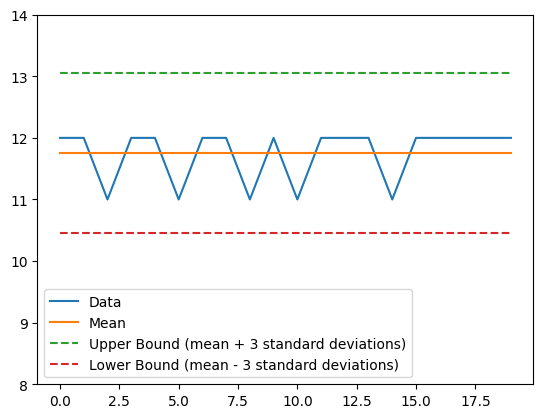

In [1]:
# imports
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

# create sample data
x_len = 20
const = np.full((1, x_len), 10)
noise = np.random.randint(1, 3, x_len)
data = const + noise

# calculate mean and standard deviation
avg = np.mean(data)
std = np.std(data)
alpha = 3
upper = avg + (alpha * std)
lower = avg - (alpha * std)

# plot the data
plt.plot(range(0, x_len), data.tolist()[0], label="Data")
plt.plot(range(0, x_len), [avg] * x_len, label="Mean")
plt.plot(range(0, x_len), [upper] * x_len, label="Upper Bound (mean + 3 standard deviations)", linestyle='--')
plt.plot(range(0, x_len), [lower] * x_len, label="Lower Bound (mean - 3 standard deviations)", linestyle='--')
plt.ylim(8, 14)
plt.legend()
plt.show()

Here we can see where the bounds or thresholds are created. If any new data points fall outside of this range, we can flag the data points as anomalous.

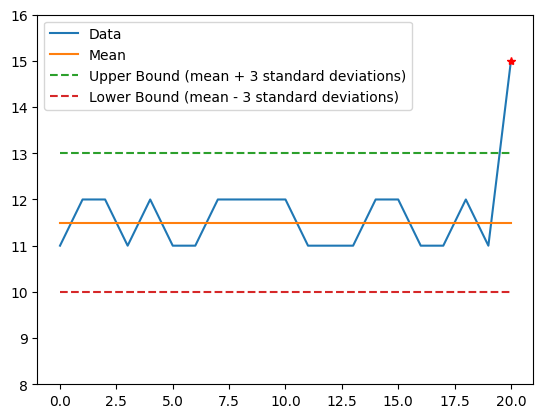

In [2]:
# create sample data
x_len = 21
const = np.full((1, x_len - 1), 10)
noise = np.random.randint(1, 3, x_len - 1)
data = const + noise

# calculate mean and standard deviation
avg = np.mean(data)
std = np.std(data)
alpha = 3
upper = avg + (alpha * std)
lower = avg - (alpha * std)

# plot the data
data_list = data.tolist()[0]
new_data = 15
data_list.append(new_data)
plt.plot(range(0, x_len), data_list, label="Data")
plt.plot(range(0, x_len), [avg] * x_len, label="Mean")
plt.plot(range(0, x_len), [upper] * x_len, label="Upper Bound (mean + 3 standard deviations)", linestyle='--')
plt.plot(range(0, x_len), [lower] * x_len, label="Lower Bound (mean - 3 standard deviations)", linestyle='--')
plt.ylim(8, 16)
# check if new data point falls inside thresholds
# flag with a red star if new data is outside threshold
if new_data > upper:
    plt.plot(20, new_data, marker="*", color="red")
else:
    plt.plot(20, new_data)
plt.legend()
plt.show()

Now we check if a new data point is outside the upper bound. If so, we flag the data point with a red star on the graph. Indicating the new data point falls outside of the desired range or thresholds. From here, when the if-condition returns True, an alert or notification can be sent out to keep interested parties informed.

## 2. Time Series Decomposition

If the data appears to have seasonality and can be formatted as a time series, a powerful technique to build upon the previous implementation is to use Time Series Decomposition.

In [3]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [4]:
np.random.seed(0)
date_rng = pd.date_range(start="2024-01-01", periods=365, freq="D")
data = np.sin(np.arange(365) * 2 * np.pi / 365) + np.random.normal(0, 0.5, 365)
ts = pd.Series(data, index=date_rng)
ts

2024-01-01    0.882026
2024-01-02    0.217292
2024-01-03    0.523791
2024-01-04    1.172066
2024-01-05    1.002581
                ...   
2024-12-26    0.263264
2024-12-27   -0.066917
2024-12-28    0.414305
2024-12-29    0.135561
2024-12-30   -0.025054
Freq: D, Length: 365, dtype: float64

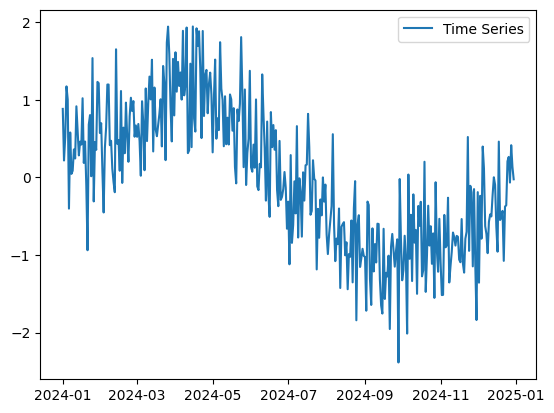

In [5]:
plt.plot(ts, label="Time Series")
plt.legend()

We've made a sample time series dataset that has a clear trend or pattern to it.

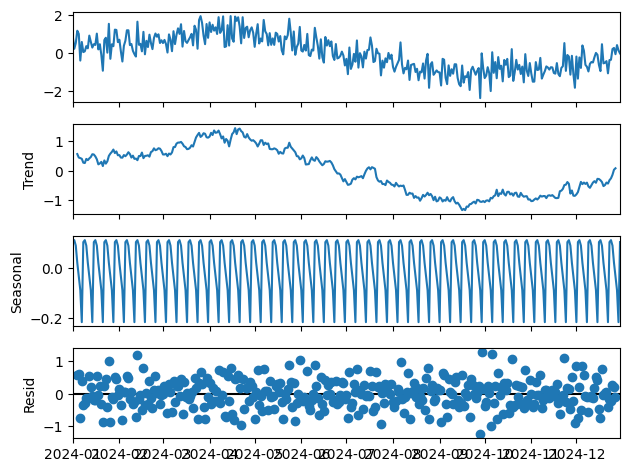

In [6]:
result_add = seasonal_decompose(ts, model='additive')
result_add.plot()
plt.show()

Using time series decomposition, we split the original time series into different components. Components in order from the top down:
1. Original time series.
2. Trend of the data.
3. Seasonality pattern found.
4. Residuals, or the difference between the trend + seasonality and the original data.

From here, we can apply the previous technique on the residuals. Specifically, we can look at the data that does not match the seasonality or trend of the data using the mean + standard deviation.

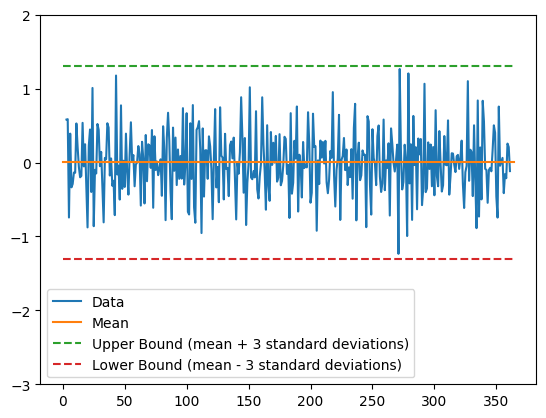

In [58]:
# calculate mean and standard deviation
# based on the residuals
data = result_add.resid
data_len = len(data)
avg = np.mean(data)
std = np.std(data)
alpha = 3
upper = avg + (alpha * std)
lower = avg - (alpha * std)

# plot the data
data_list = data.tolist()
plt.plot(range(0, data_len), data_list, label="Data")
plt.plot(range(0, data_len), [avg] * data_len, label="Mean")
plt.plot(range(0, data_len), [upper] * data_len, label="Upper Bound (mean + 3 standard deviations)", linestyle='--')
plt.plot(range(0, data_len), [lower] * data_len, label="Lower Bound (mean - 3 standard deviations)", linestyle='--')
plt.ylim(-3, 2)
plt.legend()
plt.show()

This gives us our bounds and as new data comes in, we can check against the thresholds. *See the "Mean + Standard Deviation" example for how.*

## 3. Regression Residuals

Similar to the Time Series Composition approach, we can use a regression model to produce predictions that we can cross-check against the actual data. If the difference between the model and observed data differs by more than some threshold, we classify the data point as anomalous. 

*Warning: This approach relies heavily on an accurate model.*

*Returning readers may recognize the following example from my previous post [What is Machine Learning?](https://medium.com/swlh/what-is-machine-learning-ff27b518909b)*

Create some sample data, showing the relationship between marketing dollars and revenue generated.

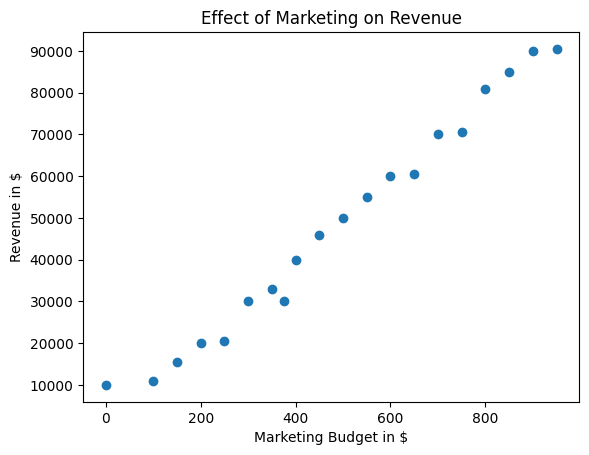

In [26]:
marketing_dollars = [0, 100, 150, 200, 250, 300, 350, 375, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950]
revenue_dollars = [10000, 11000, 15500, 20002, 20500, 30000, 33000, 30005, 40001, 45855, 50005, 55000, 60000, 60500, 70007, 70500, 80800, 85005, 90000, 90500]

plt.scatter(marketing_dollars, revenue_dollars)
plt.title('Effect of Marketing on Revenue')
plt.ylabel('Revenue in $')
plt.xlabel('Marketing Budget in $')
plt.show()

Use Scikit-Learn's Linear Regression class to create a regression model.

In [27]:
# Import Scikit-Learn to allow us to run Linear Regression
from sklearn.linear_model import LinearRegression
model = LinearRegression()

Data formatting for inputs to the model

In [28]:
# Scikit learn needs the data in a specific shape so we use NumPy to change the way the data is formatted
marketing_dollars = np.array(marketing_dollars)
revenue_dollars = np.array(revenue_dollars)
marketing_dollars = marketing_dollars.reshape(-1, 1)
revenue_dollars = revenue_dollars.reshape(-1, 1)

Train the regression model

In [29]:
fitted_model = model.fit(marketing_dollars, revenue_dollars)

Generate some predictions to find the fitted line

In [32]:
predict_X = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
fitted_line = fitted_model.predict(np.array(predict_X).reshape(-1, 1))

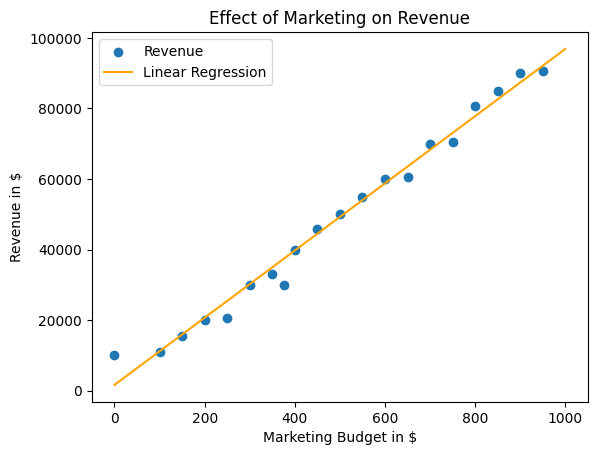

In [36]:
plt.scatter(marketing_dollars, revenue_dollars)
plt.plot(predict_X, fitted_line, color="orange")
plt.title('Effect of Marketing on Revenue')
plt.ylabel('Revenue in $')
plt.xlabel('Marketing Budget in $')
plt.legend(['Revenue', 'Linear Regression'])
plt.show()

Now we see that the Linear Regression model has it a linear line to the sample data. Any data coming in that deviates drastically from the line can be classified as anomalous.

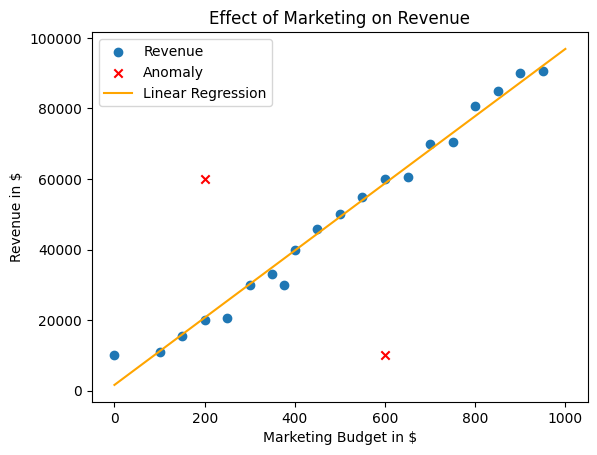

In [40]:
plt.scatter(marketing_dollars, revenue_dollars)
plt.scatter([200, 600], [60000, 10000], color="red", marker="x")
plt.plot(predict_X, fitted_line, color="orange")
plt.title('Effect of Marketing on Revenue')
plt.ylabel('Revenue in $')
plt.xlabel('Marketing Budget in $')
plt.legend(['Revenue', 'Anomaly', 'Linear Regression'])
plt.show()

The graph represents an example of how we can use the model and its predictions to determine whether new data should be classified as anomalous or not. The specific method to determine whether the new data is anomalous will vary. Using the mean + standard deviation could work, but is quite simple. It would be better to explore different calculations and approaches, for each use case, to determine what is deemed as anomalous.

## 4. Binary Classification

Instead of training a regression model, we could alternatively train a classification model to assist us in predicting whether data is anomalous or not.

We will use the same example as before, with the regression model, except we will add a Numpy array holding the labels of whether each individal row of data was anomalous or normal.

In [43]:
marketing_dollars = [0, 100, 150, 200, 250, 300, 350, 375, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950]
revenue_dollars = [10000, 11000, 15500, 60000, 20500, 30000, 33000, 30005, 40001, 45855, 9000, 55000, 60000, 60500, 70007, 20000, 80800, 85005, 90000, 90500]

X = np.column_stack([marketing_dollars, revenue_dollars])
# labels stating whether the data was anomalous or not
# 1 refers to an anomaly
anomaly = np.array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0])
y = anomaly.reshape(len(anomaly), )

For this example, we will use a Logistic Regression model to perform the classification.

In [44]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
fitted_model = model.fit(X, y)

Adding some data, both normal and anomalous, to briefly test the model.

In [45]:
test_marketing = [325, 475, 825]
test_revenue = [32000, 10000, 83000]
test_X = np.column_stack([test_marketing, test_revenue])
predictions = fitted_model.predict(test_X)

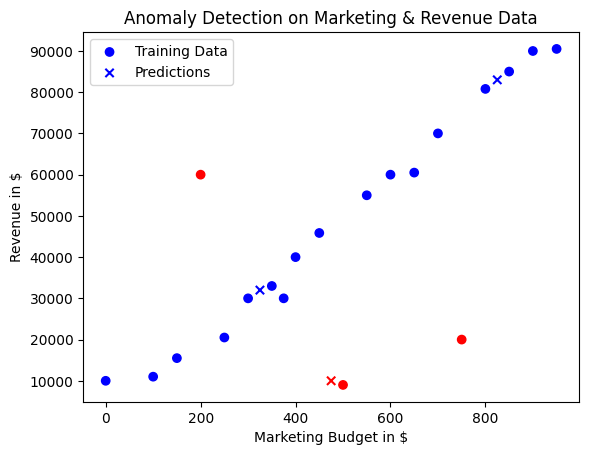

In [57]:
plt.scatter(marketing_dollars, revenue_dollars, c=anomaly, cmap='bwr')
plt.scatter(test_marketing, test_revenue, c=predictions, cmap='bwr', marker="x")
plt.title('Anomaly Detection on Marketing & Revenue Data')
plt.ylabel('Revenue in $')
plt.xlabel('Marketing Budget in $')
plt.legend(['Training Data', 'Predictions'])
plt.show()

We can see the classification model performs fairly well, in this example! The Logistic Regression approach easily classified any data following the anomalous pattern found in the training data.

## Concluding Thoughts

If using statistical techniques, make sure to know the distribution of your data. Your data may fit more of a Poisson, Normal, or some other distribution - regardless, choose your technique based on the data.

Using time series decomposition works quite well, especially if you can format your data into a time series.

Explore better and more accurate regression techniques. If you have quite a bit of data, play around with Gradient Boosting Regressors and eventually neural networks. Also, investigate which distance metric works best to compare the new data with the model predictions. If you want to dive a bit deeper into Linear Regression, here is a post that provides more information: [What is Linear Regression?](https://medium.com/data-science/what-is-linear-regression-e44d2c4bf025)

With the classification approach, take a look at Gradient Boosting Classifiers or neural networks. As for the metric, optimize for something like precision or recall. To learn more about Logistic Regression, you can do so [here.](https://medium.com/data-science/what-is-logistic-regression-d3f59ef1a9b)

To learn more about evaluating machine learning models, check out my post [Evaluation Metrics for Machine Learning](https://medium.com/data-science/evaluation-metrics-for-machine-learning-2167fca1a291)

## Bio

Frankie Cancino is a Senior Data Scientist for Mercedes-Benz Research & Development, working on AI and machine learning use cases.

### Links
* [Time Series Decomposition in Python](https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html)
* [Scikit Learn Linear Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)
* [Scikit Learn Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
* [LinkedIn](https://www.linkedin.com/in/frankie-cancino/)